In [34]:
import os, sys
# notebooks/에서 한 단계 위로 올라간 폴더를 PATH에 추가
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Map 시각화

Start: (np.int64(17), np.int64(8)) Goal: (0, 3)


(np.float64(-0.5), np.float64(671.5), np.float64(671.5), np.float64(-0.5))

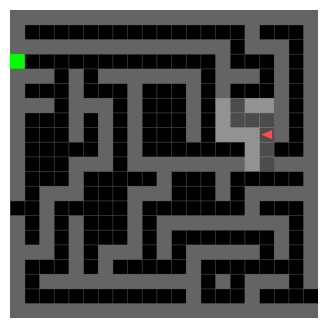

In [35]:
from env.custom_maze_env import CustomMazeEnv
import matplotlib.pyplot as plt

env = CustomMazeEnv(
    layout_id="c",
    goal_pos=(0,3),
    view_size=5,
    max_steps=250,
    tile_size=32,
    render_mode="rgb_array"    # ← 이 인자로 배열 반환이 활성화됩니다
)

obs, _ = env.reset(seed=0)
print("Start:", obs["position"], "Goal:", env.goal_pos)

img = env.render()           # 이제 numpy RGB array 반환!
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")


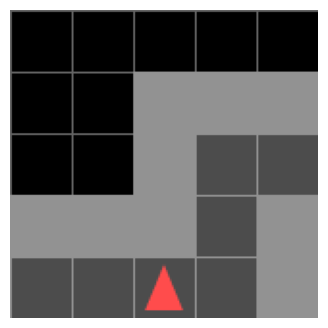

In [36]:
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper

# 1) 원본 env 생성
base_env = CustomMazeEnv(
    layout_id="c",
    goal_pos=(0,3),
    view_size=5,
    max_steps=250,
    tile_size=32,
    render_mode="rgb_array"
)

# 2) RGB 픽셀 Obs wrapper 씌우기
# tile_size 는 한 격자의 픽셀 크기(=CustomMazeEnv 에 넘긴 값과 같게)
env = RGBImgPartialObsWrapper(base_env, tile_size=32)

# 3) reset / step 하면 obs['image'] 에 (5×5×3) RGB 어레이가 담겨 있습니다.
obs, _ = env.reset(seed=0)
first_person_rgb = obs["image"]

# 4) 시각화
plt.figure(figsize=(4,4))
plt.imshow(first_person_rgb)
plt.axis("off")
plt.show()

In [37]:
first_person_rgb.shape

(160, 160, 3)

## 움직이기

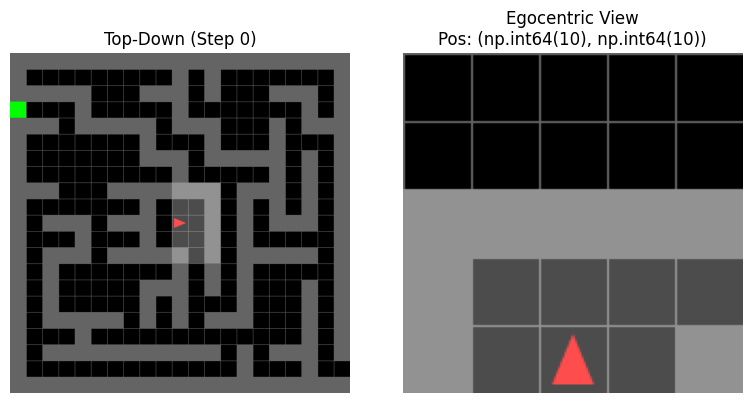

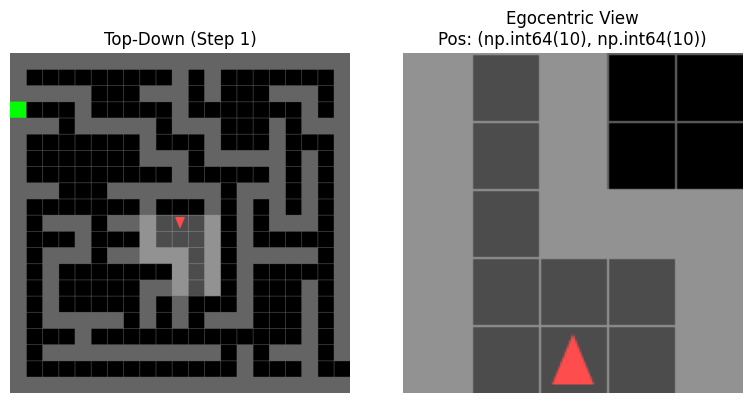

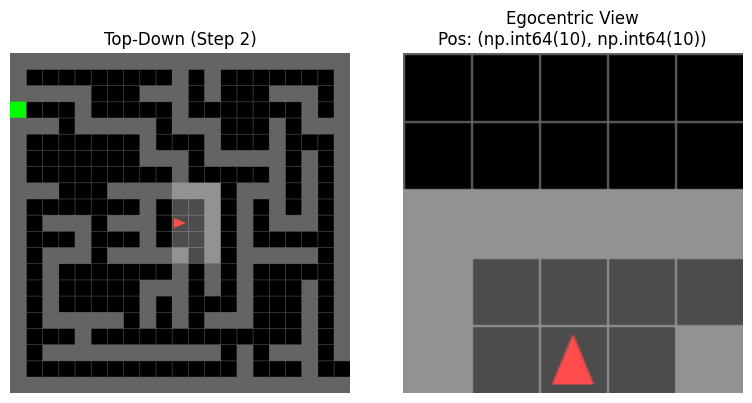

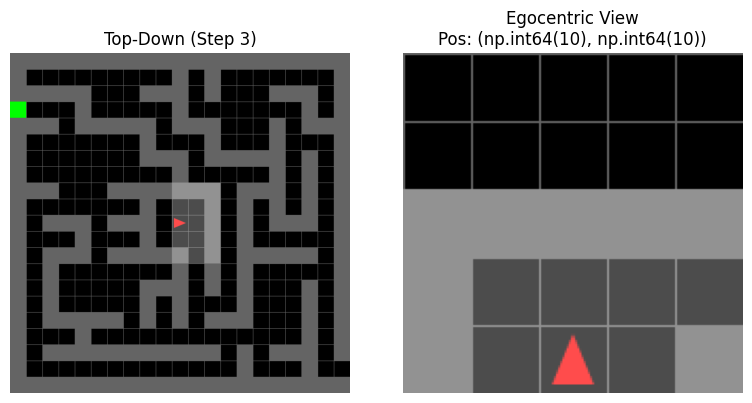

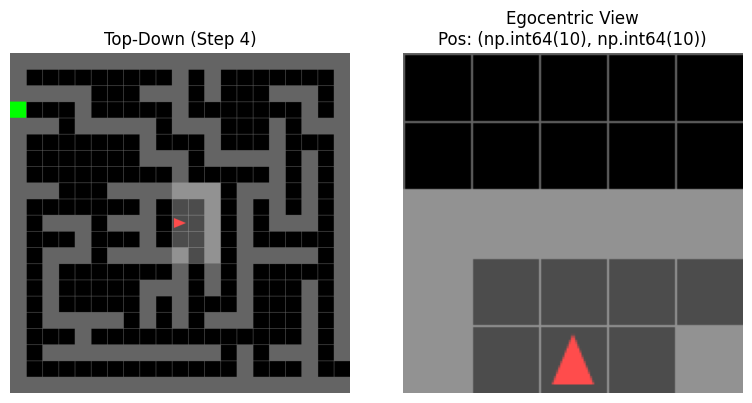

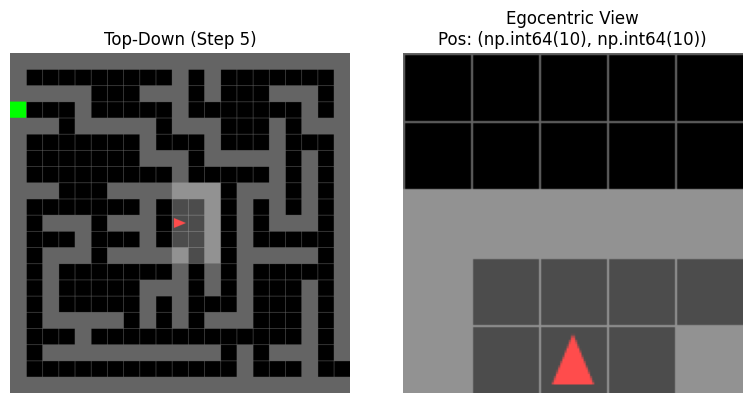

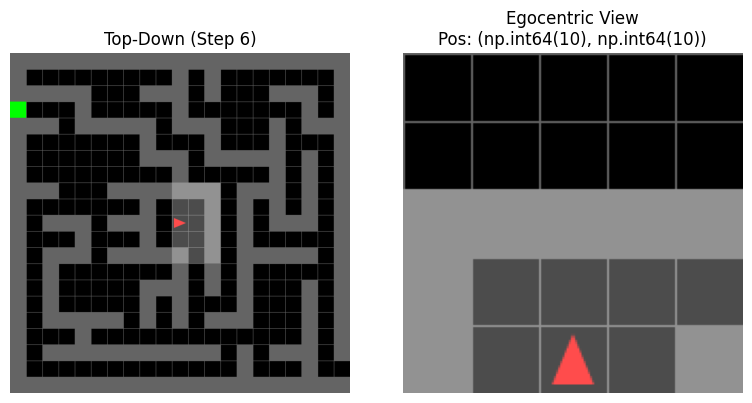

In [72]:
import matplotlib.pyplot as plt
import time
from minigrid.wrappers import RGBImgPartialObsWrapper
from env.custom_maze_env import CustomMazeEnv

# 1) Wrapper 씌운 env 생성
env = RGBImgPartialObsWrapper(
    CustomMazeEnv(
        layout_id="b",
        goal_pos=(0,3),
        view_size=5,
        max_steps=250,
        tile_size=32,
        render_mode="rgb_array"
    ),
    tile_size=32
)

# 2) 에피소드 시작
obs, _ = env.reset(seed=88)
done = False

i = 0
while i < 7:
    # ┌──────────────────────────────────┐
    # │ ① 전체 탑다운 뷰 (render)      │
    # └──────────────────────────────────┘
    full_view = env.render()            # 여전히 RGB array

    # ┌──────────────────────────────────┐
    # │ ② 1인칭 RGB 픽셀 뷰 (wrapper)  │
    # └──────────────────────────────────┘
    fp_view = obs['image']              # ← wrapper 가 주는 (160×160×3) 진짜 컬러

    # 2열 subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.imshow(full_view)
    ax1.set_title(f"Top-Down (Step {obs['timestep']})")
    ax1.axis("off")

    ax2.imshow(fp_view)
    ax2.set_title(f"Egocentric View\nPos: {obs['position']}")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()
    time.sleep(0.2)

    # 랜덤 액션 & next
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    if reward > 0:
        print(f"🎉 Goal reached at step {obs['timestep']}  Position: {obs['position']}")

    i +=1

In [73]:
full_view.shape

(672, 672, 3)

In [74]:
fp_view.shape

(160, 160, 3)

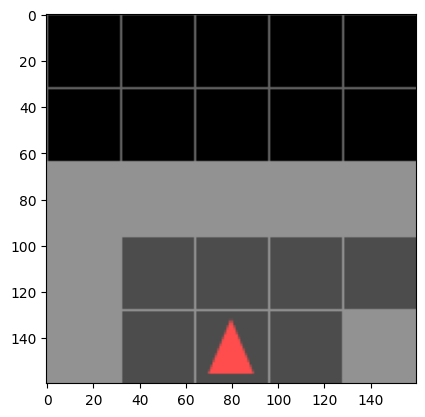

In [75]:
plt.imshow(fp_view)

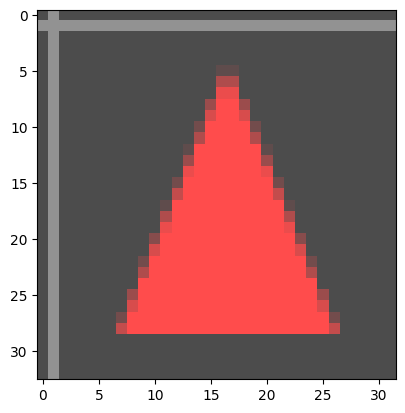

In [76]:
plt.imshow(fp_view[127:,63:95])

# ray 시각화

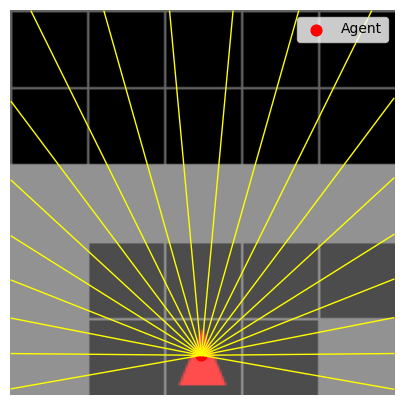

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fp_rays_fov(fp_view: np.ndarray,
                     n_rays: int = 20,
                     fov_deg: float = 200.0,
                     start=(143, 79),
                     ray_color="yellow",
                     agent_color="red",
                     figsize=(5, 5)):
    """
    fp_view(160×160×3)에 FOV(°)만큼 균등 각도로 뻗는 레이 n_rays개를 그린다.
    - start: (row, col) = (143,79) 고정
    - 화면 경계(상/좌/우)와 최초로 만나는 지점까지 그리기
    """
    H, W, _ = fp_view.shape
    sy, sx  = start

    # 중앙 방향 = '정면 위쪽' (dx=0, dy=-1)
    half = np.deg2rad(fov_deg / 2)          # ±100°  (FOV=200°)
    thetas = np.linspace(-half, half, n_rays)

    plt.figure(figsize=figsize)
    plt.imshow(fp_view)
    plt.scatter(sx, sy, c=agent_color, s=60, label="Agent")

    for θ in thetas:
        # 단위 방향벡터 (dx, dy) (y축은 아래+)
        dx, dy =  np.sin(θ), -np.cos(θ)

        # t 값을 큰 숫자로 초기화
        t_hit = float('inf')

        # ── 상단(y = 0) 교차 ─────────────────
        if dy < -1e-6:                      # 위쪽을 향할 때만
            t_top = (0 - sy) / dy
            x_top = sx + t_top * dx
            if 0 <= x_top <= W-1 and t_top > 0:
                t_hit = min(t_hit, t_top)

        # ── 좌측(x = 0) 교차 ─────────────────
        if dx < -1e-6:                      # 왼쪽을 향할 때만
            t_left = (0 - sx) / dx
            y_left = sy + t_left * dy
            if 0 <= y_left <= H-1 and t_left > 0:
                t_hit = min(t_hit, t_left)

        # ── 우측(x = W-1) 교차 ───────────────
        if dx > 1e-6:                       # 오른쪽을 향할 때만
            t_right = (W-1 - sx) / dx
            y_right = sy + t_right * dy
            if 0 <= y_right <= H-1 and t_right > 0:
                t_hit = min(t_hit, t_right)

        # 실제 끝점
        ex = sx + t_hit * dx
        ey = sy + t_hit * dy
        plt.plot([sx, ex], [sy, ey], color=ray_color, linewidth=1)

    plt.axis("off")
    plt.legend(loc="upper right")
    plt.show()

# fp_view : (160,160,3) – RGBImgPartialObsWrapper 로 얻은 1인칭 뷰
plot_fp_rays_fov(fp_view,
                 n_rays=20,
                 fov_deg=200.0,      # 200 ° 시야
                 start=(143, 79))    # 고정 시작점


# 1인칭 view reconstruct

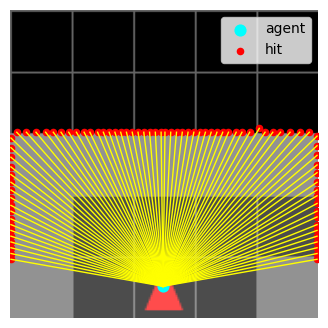

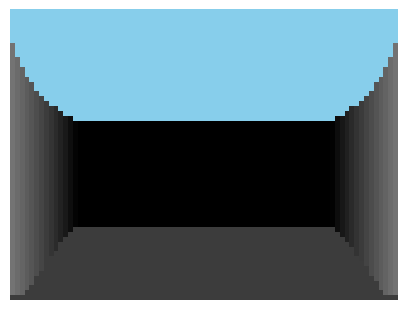

In [78]:
import numpy as np, matplotlib.pyplot as plt

COLORS = np.array([[135,206,235], [150,150,150], [60,60,60]], dtype=np.float32)/255.

def reconstruct(fp,            # ← 함수 이름만 축약
                n_rays=80,      # **** 가로 80 픽셀 (2° 간격) ****
                fov_h=160,      # **** 수평 시야각 160° ****
                fov_v=120,
                eye_h=180, wall_h=250,
                px_per_cm=1/5, d_max_cm=300, wall_thr=50):
    """fp : (160,160,3) RGB → (60,80,3) + 디버그 그림"""
    out_h, out_w = 60, 80       # **** 세로 60 픽셀 ****

    H, W, _ = fp.shape
    sy, sx  = 143, 79
    θs      = np.deg2rad(np.linspace(-fov_h/2, fov_h/2, n_rays))
    v       = np.stack([np.sin(θs), -np.abs(np.cos(θs))], 1)   # (80,2) 위쪽만
    gray    = fp.mean(2)

    hit_xy  = np.zeros((n_rays, 2), int);  d_px = np.zeros(n_rays)
    for i, (vx, vy) in enumerate(v):
        t = [t for t in [ (0-sy)/vy if vy<0 else np.inf,
                          (0-sx)/vx if vx<0 else np.inf,
                          ((W-1)-sx)/vx if vx>0 else np.inf ] if t>0]
        t_hit = min(t)
        step  = 0.0
        while step <= t_hit:
            y = int(round(sy + vy*step)); x = int(round(sx + vx*step))
            if gray[y, x] <= wall_thr: break
            step += 0.5
        hit_xy[i] = (x, y); d_px[i] = step

    d_cm = d_px/px_per_cm*np.abs(np.cos(θs))
    d_cm = np.clip(d_cm, 0, d_max_cm)
    d_m  = d_cm/100
    θ_floor = np.arctan2(-eye_h/100,        d_m)
    θ_wall  = np.arctan2((wall_h-eye_h)/100,d_m)

    fov_v_rad = np.deg2rad(fov_v)
    top, bot  = fov_v_rad/2, -fov_v_rad/2
    ang2row = lambda th: np.clip(((top-th)/fov_v_rad*out_h).astype(int),
                                 0, out_h-1)
    sky_r, floor_r = ang2row(θ_wall), ang2row(θ_floor)

    img = np.zeros((out_h, out_w, 3), np.float32)
    for c in range(n_rays):
        s, f = sky_r[c], floor_r[c]
        shade = 1 - d_cm[c]/d_max_cm
        img[0:s , c] = COLORS[0]
        img[s:f, c]  = COLORS[1] * shade
        img[f:  , c] = COLORS[2]

    # 디버그 시각화
    fig, ax = plt.subplots(figsize=(4,4)); ax.imshow(fp)
    ax.scatter(sx, sy, c='cyan', s=60, label='agent')
    for (hx, hy) in hit_xy: ax.plot([sx, hx], [sy, hy], c='yellow', lw=1)
    ax.scatter(hit_xy[:,0], hit_xy[:,1], c='red', s=20, label='hit')
    ax.axis('off'); ax.legend(); plt.show()

    return img


# 예시 사용
recon = reconstruct(fp_view)        # fp_view = obs["image"]
plt.figure(figsize=(5,4)); plt.imshow(recon); plt.axis("off"); plt.show()


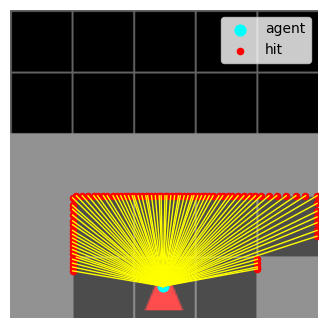

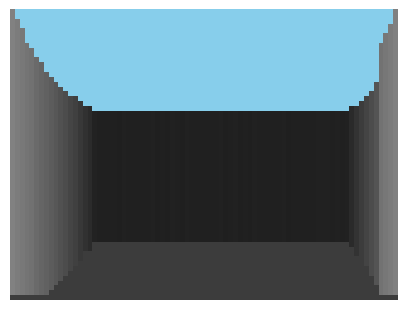

In [79]:
import numpy as np
import matplotlib.pyplot as plt

COLORS = np.array([
    [135, 206, 235],  # sky
    [150, 150, 150],  # wall base
    [ 60,  60,  60],  # floor
], dtype=np.float32) / 255.0

def reconstruct(fp_view,            # (160×160×3) → (60×80×3)
                n_rays=80,          # 가로 80 (2° 간격)
                fov_h=160,          # 수평 160°
                fov_v=120,          # 수직 120°
                eye_h=180, wall_h=250,
                px_per_cm=1/5, d_max_cm=300,
                wall_value=146):    # 벽 픽셀값 (정수)
    """
    fp_view : uint8 RGB array (160×160×3)
    returns : (60,80,3) reconstructed RGB + debug viz
    """
    out_h, out_w = 60, 80
    H, W, _      = fp_view.shape
    sy, sx       = 143, 79

    # grayscale for checking
    gray = fp_view.mean(axis=2).astype(np.int32)

    # precompute ray directions
    thetas = np.deg2rad(np.linspace(-fov_h/2, fov_h/2, n_rays))
    dirs   = np.stack([np.sin(thetas), -np.abs(np.cos(thetas))], axis=1)

    hit_xy = np.zeros((n_rays, 2), int)
    d_px   = np.zeros(n_rays)

    # DDA with consecutive-3 check
    for i, (vx, vy) in enumerate(dirs):
        # t to image boundary
        ts = []
        if vy < 0: ts.append((0   - sy)/vy)
        if vx < 0: ts.append((0   - sx)/vx)
        if vx > 0: ts.append(((W-1)-sx)/vx)
        t_hit = min(t for t in ts if t>0)

        step = 0.0
        consec = 0
        start_step = 0.0
        found = False

        # sample along ray in 1px increments
        while step <= t_hit:
            y = int(round(sy + vy*step))
            x = int(round(sx + vx*step))

            # check exact wall value
            if gray[y, x] == wall_value:
                if consec == 0:
                    start_step = step
                consec += 1
                if consec >= 5:
                    # hit at first of the 3
                    y0 = int(round(sy + vy*start_step))
                    x0 = int(round(sx + vx*start_step))
                    hit_xy[i] = (x0, y0)
                    d_px[i]   = start_step
                    found = True
                    break
            else:
                consec = 0

            step += 1.0

        # if no wall found, default to boundary hit
        if not found:
            y0 = int(round(sy + vy*t_hit))
            x0 = int(round(sx + vx*t_hit))
            hit_xy[i] = (x0, y0)
            d_px[i]   = t_hit

    # pixel→cm 거리 (수평 직교 보정)
    d_cm = (d_px / px_per_cm) * np.abs(np.cos(thetas))
    d_cm = np.clip(d_cm, 0, d_max_cm)
    d_m  = d_cm / 100.0

    # 수직 각도 계산
    eye_h_m = eye_h / 100.0
    wall_h_m= wall_h / 100.0
    theta_floor = np.arctan2(-eye_h_m,        d_m)
    theta_wall  = np.arctan2(wall_h_m-eye_h_m, d_m)

    # 각도→행 인덱스 (0=sky, out_h-1=floor)
    fov_v_rad = np.deg2rad(fov_v)
    top, bot  =  fov_v_rad/2, -fov_v_rad/2
    def ang2row(th):
        return np.clip(((top - th)/fov_v_rad * out_h).astype(int),
                       0, out_h-1)

    sky_r, floor_r = ang2row(theta_wall), ang2row(theta_floor)

    # 60×80 재구성
    recon = np.zeros((out_h, out_w, 3), np.float32)
    for c in range(n_rays):
        s, f = sky_r[c], floor_r[c]
        shade = 1.0 - (d_cm[c] / d_max_cm)
        recon[ 0:s  , c] = COLORS[0]
        recon[s: f , c] = COLORS[1] * shade
        recon[f:    , c] = COLORS[2]

    # 디버그: fp_view 위에 레이+hit
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(fp_view)
    ax.scatter([sx],[sy], c='cyan', s=60, label='agent')
    for (hx, hy), (vx, vy) in zip(hit_xy, dirs):
        ax.plot([sx, hx], [sy, hy], c='yellow', lw=1)
    ax.scatter(hit_xy[:,0], hit_xy[:,1], c='red', s=20, label='hit')
    ax.axis('off'); ax.legend(); plt.show()

    return recon

# 사용 예시
recon_img = reconstruct(fp_view)
plt.figure(figsize=(5,4)); plt.imshow(recon_img); plt.axis("off"); plt.show()


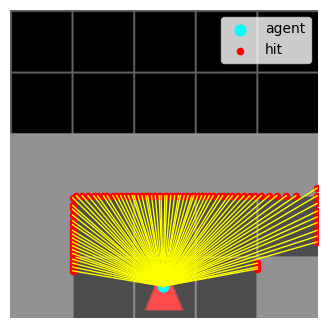

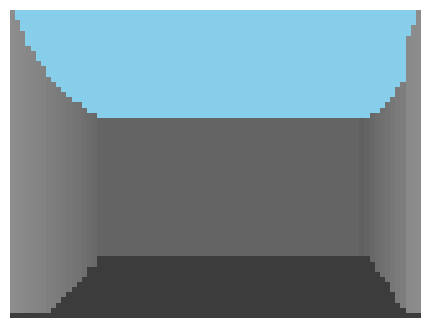

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# 색 팔레트: [sky, wall, floor]
COLORS = np.array([
    [135, 206, 235],  # sky
    [150, 150, 150],  # wall
    [ 60,  60,  60],  # floor
], dtype=np.float32) / 255.0

def reconstruct(fp_view,
                n_rays=80,    # 가로 80픽셀 (2° 간격)
                fov_h=160,    # 수평 시야각 160°
                fov_v=120,    # 수직 시야각 120°
                eye_h=180,    # 눈 높이(cm)
                wall_h=250,   # 벽 높이(cm)
                px_per_cm=1/5,
                d_max_cm=300,
                wall_value=146):
    """
    fp_view: (160,160,3) RGB 1인칭 뷰
    반환:    (60,80,3) 재구성 이미지 + 디버그 레이 시각화
    """
    # 0) 출력 해상도
    out_h, out_w = 60, 80

    H, W, _ = fp_view.shape
    sy, sx  = 143, 79   # 에이전트 발끝 픽셀 좌표

    # 그레이스케일로 변환
    gray = fp_view.mean(2).astype(int)

    # 1) Ray 방향 벡터 준비
    thetas = np.deg2rad(np.linspace(-fov_h/2, fov_h/2, n_rays))
    dirs   = np.stack([np.sin(thetas), -np.abs(np.cos(thetas))], 1)

    # 히트 포인트 저장용
    hit_xy = np.zeros((n_rays, 2), int)
    d_px   = np.zeros(n_rays)

    # 2) RayCast + “연속 3픽셀 벽” 검사
    for i, (vx, vy) in enumerate(dirs):
        # 화면 경계까지의 최대 t
        ts = [
            (0 - sy) / vy if vy < 0 else np.inf,
            (0 - sx) / vx if vx < 0 else np.inf,
            ((W-1) - sx) / vx if vx > 0 else np.inf
        ]
        t_hit = min(t for t in ts if t > 0)

        consec = 0
        step   = 0.0
        found  = False
        start  = 0.0

        while step <= t_hit:
            y = int(round(sy + vy * step))
            x = int(round(sx + vx * step))

            if gray[y, x] == wall_value:
                if consec == 0:
                    start = step
                consec += 1
                if consec >= 10:
                    # 연속 3픽셀을 모두 wall_value로 만났다면 hit
                    y0, x0 = int(round(sy + vy * start)), int(round(sx + vx * start))
                    hit_xy[i] = (x0, y0)
                    d_px[i]   = start
                    found = True
                    break
            else:
                consec = 0

            step += 1.0

        if not found:
            # 벽을 만나지 못하면 경계 지점에서 강제종료
            y0, x0 = int(round(sy + vy * t_hit)), int(round(sx + vx * t_hit))
            hit_xy[i] = (x0, y0)
            d_px[i]   = t_hit

    # 3) 픽셀→cm 변환 & 각도 계산
    d_cm = (d_px / px_per_cm) * np.abs(np.cos(thetas))
    d_cm = np.clip(d_cm, 0, d_max_cm)
    d_m  = d_cm / 100.0  # 미터 단위

    theta_floor = np.arctan2(-eye_h/100.0,        d_m)
    theta_wall  = np.arctan2((wall_h-eye_h)/100.0, d_m)

    # 4) 각도→화면 row 인덱스
    fov_v_rad = np.deg2rad(fov_v)
    top, bot  = fov_v_rad/2, -fov_v_rad/2
    ang2row   = lambda th: np.clip(((top - th)/fov_v_rad * out_h).astype(int), 0, out_h-1)

    sky_r   = ang2row(theta_wall)
    floor_r = ang2row(theta_floor)

    # 5) 이상치 제거 (좌우 3픽셀 median smoothing)
    sky_s   = sky_r.copy()
    floor_s = floor_r.copy()
    for j in range(1, out_w-1):
        sky_s[j]   = np.median(sky_r[j-1:j+2])
        floor_s[j] = np.median(floor_r[j-1:j+2])
    sky_r, floor_r = sky_s, floor_s

    # 6) 60×80 재구성 (히트 y 기준 음영)
    img = np.zeros((out_h, out_w, 3), np.float32)
    for c in range(n_rays):
        s, f = sky_r[c], floor_r[c]
        hy   = hit_xy[c, 1]

        # 화면 위(y=0)→아래(y=sy)에서 hy 비례 밝기
        shade = np.clip(hy / sy, 0.0, 1.0)

        img[0:s  , c] = COLORS[0]           # sky
        img[s:f  , c] = COLORS[1] * shade   # wall
        img[f:   , c] = COLORS[2]           # floor

    # 7) 디버그: 레이 + 히트 지점
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(fp_view)
    ax.scatter([sx],[sy], c='cyan', s=60, label='agent')
    for (hx, hy) in hit_xy:
        ax.plot([sx, hx], [sy, hy], c='yellow', lw=1)
    ax.scatter(hit_xy[:,0], hit_xy[:,1], c='red', s=20, label='hit')
    ax.axis('off')
    ax.legend()
    plt.show()

    return img

# 사용 예
# fp_view = obs["image"] 로 얻은 (160,160,3) 어레이
recon = reconstruct(fp_view)
plt.figure(figsize=(6,4))
plt.imshow(recon)
plt.axis("off")
plt.show()
